In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import plot_tree

import xgboost as xgb

import os

In [2]:
#### HELPER FUNCTIONS ####


def plot_predicted_distribtuions(trained_model):
    ys = [y_train, y_test]
    Xs = [X_train, X_test]
    titles = ['Train Distribution', 'Test Distribution']

    fix, ax = plt.subplots(1, 2, figsize=(12,6))
    for i in range(2):
        counts, bins = np.histogram(ys[i])
        counts_pred, bins_pred = np.histogram(trained_model.predict(Xs[i]))

        ax[i].hist(bins[:-1], bins, weights=counts, label='Actual Distribtuion', color='black')
        ax[i].hist(bins[:-1], bins_pred, weights=counts_pred, label='Predicted Distribtuion', color='red', alpha=0.75)
        ax[i].legend()
        ax[i].set_title(f'{titles[i]}')
    plt.show()


def plot_feature_importances(trained_model, training_set, top_n=15, figsize=(8,10)):
  features = training_set.columns
  importances = trained_model.feature_importances_
  df = pd.DataFrame()
  df['Feature'] = features
  df['Importance'] = importances
  df.sort_values(by='Importance', ascending=False, inplace=True)
  df = df.head(top_n)

  plt.figure(figsize=figsize)
  sns.barplot(data=df, x='Importance', y='Feature', color='blue')
  plt.title(f'Top {top_n} Features')
  plt.show()


def plot_forest(trained_model, training_set, n_trees=100, n_rows=20, n_cols=5, figsize=(100,100), class_name='Yield Per Colony',
                is_gb=False, is_xgb=False, savefig=False, dpi=300):
  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  column_names = training_set.columns
  ax = axes.ravel()
  if not is_xgb:
    estimators = trained_model.estimators_.reshape(n_trees,) if is_gb else trained_model.estimators_

  for i in range(n_trees):
    if is_xgb:
      xgb.plot_tree(trained_model, num_trees=i, ax=ax[i])
    else:
      plot_tree(estimators[i],
            feature_names=column_names,
            class_names=class_name,
            filled=True, impurity=True,
            rounded=True, ax=ax[i])
      ax[i].set_title(f'Estimator {i+1}')
  if savefig:
    plt.savefig('trees.png', dpi=dpi)
  plt.show()


def train_test_MSE(trained_model, y_test, X_train):
  y_preds = trained_model.predict(X_test)
  MSE_test = mean_squared_error(y_test, y_preds)
  MSE_train = mean_squared_error(y_train, model.predict(X_train))
  RMSE_test, RMSE_train = np.sqrt(MSE_test), np.sqrt(MSE_train)
  print(f'MSE_test: {MSE_test:.2f}\nMSE_train: {MSE_train:.2f}')
  print(f'RMSE_test: {RMSE_test:.2f}\nRMSE_train: {RMSE_train:.2f}')

# Loading data

In [3]:
# Uses this CSV from Data
df = pd.read_csv('../04 - Data/Final Data/final_data_dummies.csv')

In [4]:
# Set train and test set, test is anything beyond 2016
train = df[df['year'] < 2016]
test = df[df['year'] >= 2016]
X_train = train.drop(columns='yieldpercol')
y_train = train['yieldpercol']
X_test = test.drop(columns='yieldpercol')
y_test = test['yieldpercol']

# Running Matt's models

MSE_test: 85.06
MSE_train: 33.70
RMSE_test: 9.22
RMSE_train: 5.81


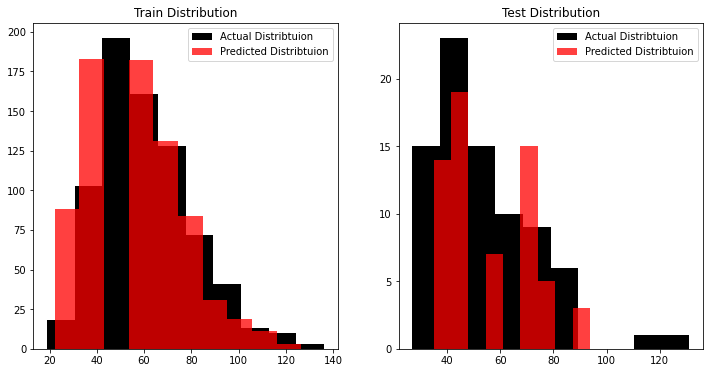

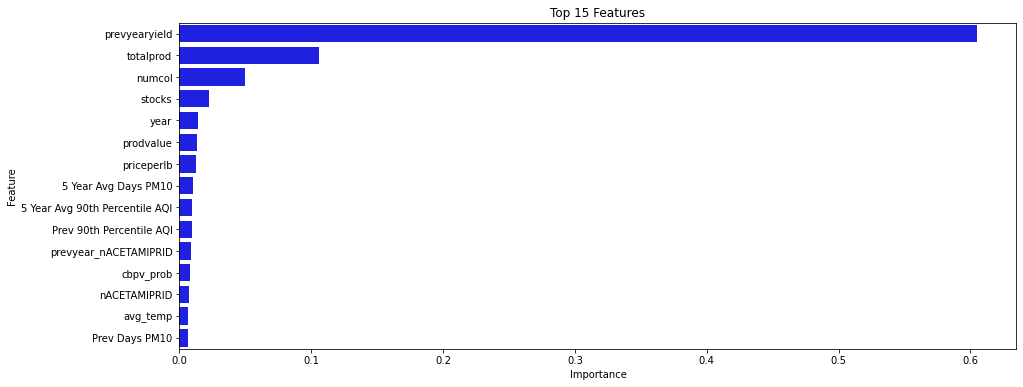

In [5]:
### GradientBoost
model = GradientBoostingRegressor(n_estimators=100, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=15, figsize=(15, 6))

In [6]:
base_estimate = np.mean(y_train)
print(f'Base Estimate = {base_estimate:.2f}')

Base Estimate = 60.93


In [7]:
#### Try GBT again but drop some columns
# Set train and test set, test is anything beyond 2016
df_dropped_cols = df.copy()
df_dropped_cols.columns
df_dropped_cols.rename(columns = lambda x: x.replace(' ', '_'), inplace=True) # Remove whitespace
df_dropped_cols.drop(columns=['totalprod', 'prodvalue', 'stocks', 'priceperlb'], inplace=True)
train = df_dropped_cols[df_dropped_cols['year'] < 2016].copy()
test = df_dropped_cols[df_dropped_cols['year'] >= 2016].copy()
train.drop(columns='year', inplace=True)
test.drop(columns='year', inplace=True)
X_train = train.drop(columns='yieldpercol').copy()
y_train = train['yieldpercol'].copy()
X_test = test.drop(columns='yieldpercol').copy()
y_test = test['yieldpercol'].copy()



MSE_test: 111.94
MSE_train: 52.66
RMSE_test: 10.58
RMSE_train: 7.26


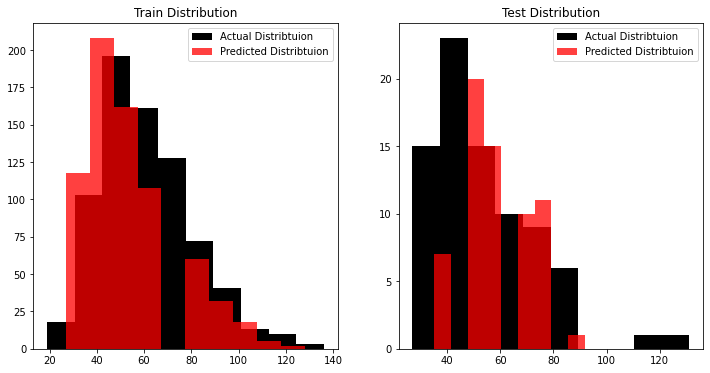

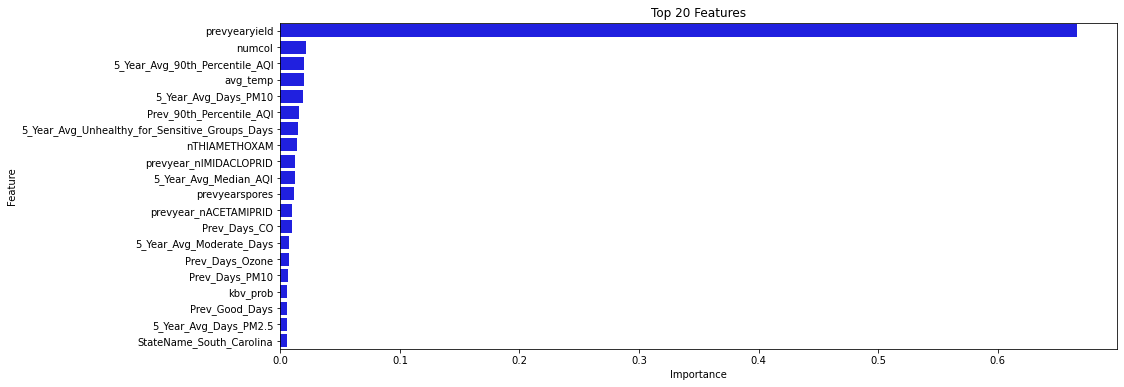

In [8]:
### GradientBoost: dropped 4 cols related to yieldpercol and year
model = GradientBoostingRegressor(n_estimators=100, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

MSE_test: 121.32
MSE_train: 4.97
RMSE_test: 11.01
RMSE_train: 2.23


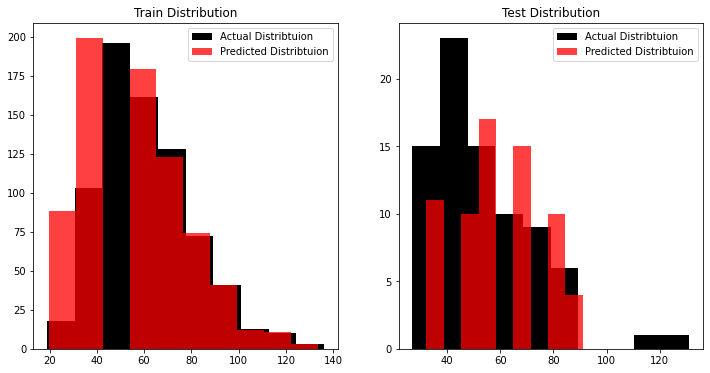

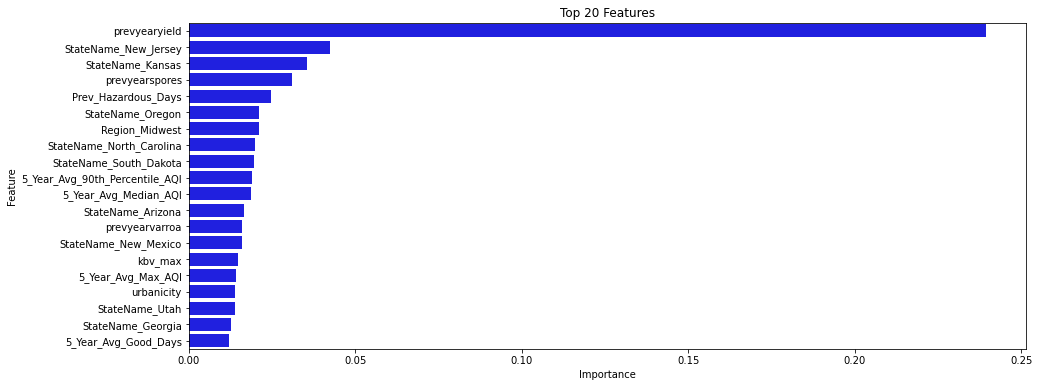

In [9]:
# Same data as above but "X Gradient Boost" instead of "Gradient Boost"
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

/Users/mattlampl/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


MSE_test: 123.31
MSE_train: 4.28
RMSE_test: 11.10
RMSE_train: 2.07


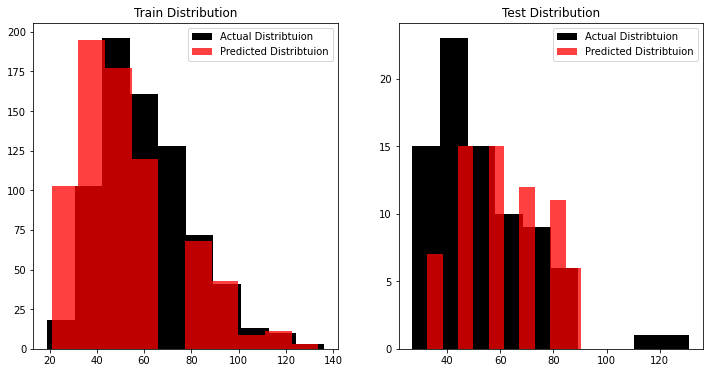

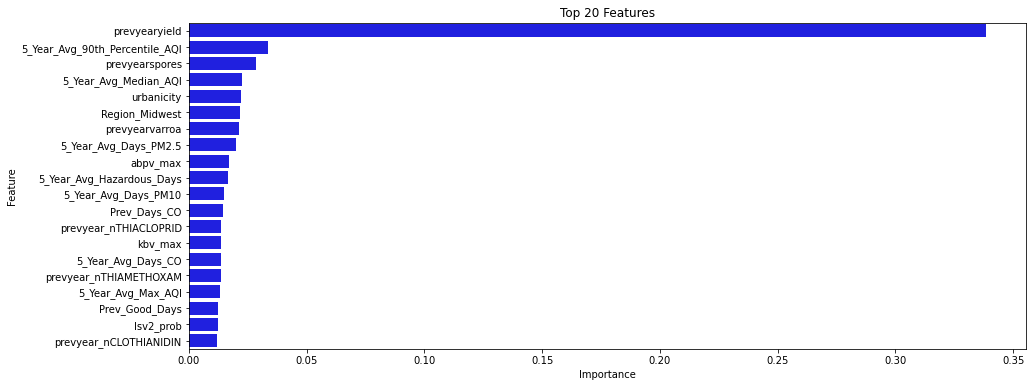

In [10]:
# no_states = [col for col in df_dropped_cols.columns if ]
df_no_states = df_dropped_cols[[col for col in df_dropped_cols.columns if 'StateName' not in col]]
train = df_no_states[df_no_states['year'] < 2016]
test = df_no_states[df_no_states['year'] >= 2016]
train.drop(columns='year', inplace=True)
test.drop(columns='year', inplace=True)
X_train = train.drop(columns='yieldpercol')
y_train = train['yieldpercol']
X_test = test.drop(columns='yieldpercol')
y_test = test['yieldpercol']
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)
train_test_MSE(model, y_test, X_train)
plot_predicted_distribtuions(model)
plot_feature_importances(model, X_train, top_n=20, figsize=(15, 6))

# Simulation
Sampling by state and including state in simulation model

In [11]:
# Building full dataset
df_dropped_cols = df.copy()
df_dropped_cols.rename(columns = lambda x: x.replace(' ', '_'), inplace=True) # Remove whitespace
df_dropped_cols.drop(columns=[
  'totalprod', 'prodvalue', 'stocks', 'priceperlb'
], inplace=True)
X = df_dropped_cols.drop(columns=['year','yieldpercol']).copy()
y = df_dropped_cols.loc[:,'yieldpercol'].copy()

# Training model on full dataset
sim_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, random_state=123)
sim_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123, ...)

## Defining sampling distribution of columns in X

In [12]:
# Reviewing columns
X.columns[:69]

Index(['numcol', 'nCLOTHIANIDIN', 'nIMIDACLOPRID', 'nTHIAMETHOXAM',
       'nACETAMIPRID', 'nTHIACLOPRID', 'nAllNeonic', 'prevyear_nCLOTHIANIDIN',
       'prevyear_nIMIDACLOPRID', 'prevyear_nTHIAMETHOXAM',
       'prevyear_nACETAMIPRID', 'prevyear_nTHIACLOPRID',
       'NorthDakota_PrevYear', 'prevyearyield', 'avg_temp', 'anomaly',
       'varroa', 'spores', 'cbpv_max', 'dwv_max', 'iapv_max', 'kbv_max',
       'sbpv_max', 'abpv_max', 'dwv-b_max', 'lsv2_max', 'mkv_max', 'cbpv_prob',
       'dwv_prob', 'iapv_prob', 'kbv_prob', 'sbpv_prob', 'abpv_prob',
       'dwv-b_prob', 'lsv2_prob', 'mkv_prob', 'prevyearspores',
       'prevyearvarroa', 'urbanicity', 'Prev_Days_with_AQI', 'Prev_Good_Days',
       'Prev_Moderate_Days', 'Prev_Unhealthy_for_Sensitive_Groups_Days',
       'Prev_Unhealthy_Days', 'Prev_Very_Unhealthy_Days',
       'Prev_Hazardous_Days', 'Prev_Max_AQI', 'Prev_90th_Percentile_AQI',
       'Prev_Median_AQI', 'Prev_Days_CO', 'Prev_Days_NO2', 'Prev_Days_Ozone',
       'Prev_Days

In [13]:
# Building distribution dictionary
state_names = [i[10:] for i in X.columns if i[:9] == 'StateName']
dist_by_state = dict()

for state in state_names:
  dist_by_state[state] = dict()
  for col in X.columns[:69]:
    dist_by_state[state][col] = dict()

    # Save state min
    dist_by_state[state][col]['min'] = X[
      X[f'StateName_{state}'] == 1
    ][col].min()

    # Save state max
    dist_by_state[state][col]['max'] = X[
      X[f'StateName_{state}'] == 1
    ][col].max()

    # Compute and save state range
    dist_by_state[state][col]['range'] = \
      dist_by_state[state][col]['max'] - dist_by_state[state][col]['min']

In [14]:
X[
  X.StateName_Alabama == 1
].iloc[:,69:].agg(['mean'])

,StateName_Alabama,StateName_Arizona,StateName_Arkansas,StateName_California,StateName_Colorado,StateName_Florida,StateName_Georgia,StateName_Hawaii,StateName_Idaho,StateName_Illinois,...,StateName_Vermont,StateName_Virginia,StateName_Washington,StateName_West_Virginia,StateName_Wisconsin,StateName_Wyoming,Region_Midwest,Region_Northeast,Region_South,Region_West
mean,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
dist_by_state['Alabama']['Prev_Moderate_Days']

{'min': 31.12, 'max': 113.65, 'range': 82.53}

In [16]:
# Building simulated dataset
df_list = list()
for state in state_names:
  # Create container dict for state df
  df_dict = dict()

  for col in X.columns[:69]:
    # Generating uniformly distributed data between [0,1)
    data = np.random.rand(1000)

    # Scaling data to the min/max of the relevant column
    data = data * dist_by_state[state][col]['range'] + dist_by_state[state][col]['min']

    # Storing synthetic column in dict
    df_dict[col] = data

  # Add state/region dummies
  state_df = pd.DataFrame(df_dict)
  for col in X.columns[69:]:
    state_df.loc[:,col] = X[
      X[f'StateName_{state}'] == 1
    ][col].mean()

  # Append state_df to df_list
  df_list.append(state_df)

sim_X = pd.concat(df_list)

In [17]:
sim_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44000 entries, 0 to 999
Columns: 117 entries, numcol to Region_West
dtypes: float64(117)
memory usage: 39.6 MB


In [18]:
sim_X.head()

,numcol,nCLOTHIANIDIN,nIMIDACLOPRID,nTHIAMETHOXAM,nACETAMIPRID,nTHIACLOPRID,nAllNeonic,prevyear_nCLOTHIANIDIN,prevyear_nIMIDACLOPRID,prevyear_nTHIAMETHOXAM,...,StateName_Vermont,StateName_Virginia,StateName_Washington,StateName_West_Virginia,StateName_Wisconsin,StateName_Wyoming,Region_Midwest,Region_Northeast,Region_South,Region_West
0,7653.141147,3458.965826,4922.194431,2296.195788,227.947443,2.395213,15171.220658,1366.956378,1470.043684,4022.096167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,12224.538871,11.168575,10459.883154,3306.650243,89.037695,2.425640,16286.655047,4200.864982,8223.224304,5872.765834,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,11755.950204,8165.994276,5712.877604,2491.342908,205.157923,0.488096,28628.270981,12038.593963,5307.491041,8115.448367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8569.203400,1079.909397,6080.876629,6007.863786,243.913181,0.922069,31490.494525,5656.600502,10584.753991,2227.298666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,12517.610837,12630.674914,7639.943503,1924.866013,245.443359,1.080123,20762.415108,12012.478338,2276.825815,9808.472469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Getting predictions

In [19]:
sim_y = sim_model.predict(sim_X)

In [20]:
sim_df = pd.concat([
  pd.DataFrame({'sim_predictions':sim_y}).reset_index().iloc[:,1:],
  sim_X.reset_index().iloc[:,1:]
], axis=1)

# Exploring predictions

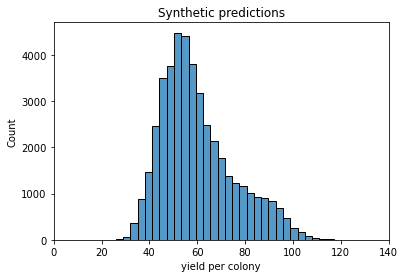

In [21]:
ax = sns.histplot(sim_df.sim_predictions, bins=30)
ax.set_xlim((0,140))
ax.set_title('Synthetic predictions')
ax.set_xlabel('yield per colony')
plt.show()

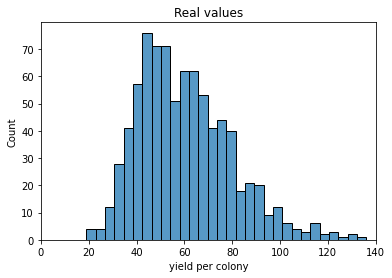

In [22]:
ax = sns.histplot(y, bins=30)
ax.set_xlim((0,140))
ax.set_title('Real values')
ax.set_xlabel('yield per colony')
plt.show()

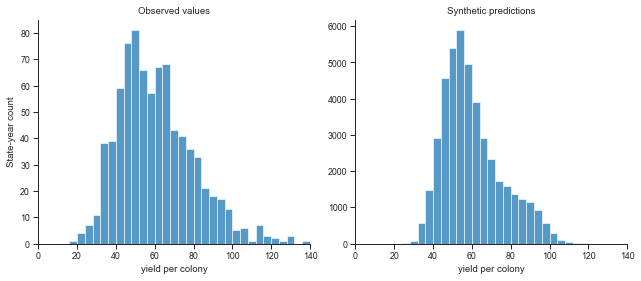

In [23]:
sns.set_context('paper')
sns.set_style('ticks')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4), tight_layout=True)

sns.histplot(y, bins=np.arange(0,141,4), ax=ax1)
ax1.set_xlim((0,140))
ax1.set_title('Observed values')
ax1.set_xlabel('yield per colony')
ax1.set_ylabel('State-year count')

sns.histplot(sim_df.sim_predictions, bins=np.arange(0,141,4), ax=ax2)
ax2.set_xlim((0,140))
ax2.set_title('Synthetic predictions')
ax2.set_xlabel('yield per colony')
ax2.set_ylabel('')

sns.despine()
plt.show()

In [24]:
len(y)

825

#### First notes
Synthetic distribution is pretty similar, though a bit narrower in the tails, than true distribution.

In [25]:
top_10pct = sim_df.sort_values('sim_predictions', ascending=False).iloc[:4400].mean()
bottom_90pct = sim_df.sort_values('sim_predictions', ascending=False).iloc[4400:].mean()

In [26]:
total_mean = sim_df.mean()

In [27]:
total_range = sim_df.max() - sim_df.min()

In [28]:
total_rel_mean_diff = (top_10pct - bottom_90pct) / total_range

In [29]:
total_rel_mean_diff

sim_predictions      0.388554
numcol               0.110911
nCLOTHIANIDIN       -0.018359
nIMIDACLOPRID       -0.003274
nTHIAMETHOXAM        0.051557
                       ...   
StateName_Wyoming   -0.020202
Region_Midwest      -0.034596
Region_Northeast    -0.117677
Region_South         0.114899
Region_West          0.037374
Length: 118, dtype: float64

In [30]:
best_features = total_rel_mean_diff.sort_values(ascending=False).head(25)
best_features

sim_predictions             0.388554
prevyearyield               0.344915
StateName_Hawaii            0.208333
StateName_Louisiana         0.203030
prevyearspores              0.175895
5_Year_Avg_Good_Days        0.142730
StateName_North_Dakota      0.119949
Region_South                0.114899
Prev_Good_Days              0.114021
StateName_Mississippi       0.111616
numcol                      0.110911
lsv2_max                    0.106084
5_Year_Avg_Days_with_AQI    0.082852
cbpv_max                    0.082181
5_Year_Avg_Days_PM2.5       0.078673
StateName_Montana           0.076515
abpv_prob                   0.076510
Prev_Days_PM2.5             0.070309
Prev_Days_PM10              0.069493
StateName_Florida           0.056818
avg_temp                    0.055572
Prev_Days_with_AQI          0.051579
nTHIAMETHOXAM               0.051557
iapv_max                    0.051148
prevyear_nTHIAMETHOXAM      0.041197
dtype: float64

In [31]:
worst_features = total_rel_mean_diff.sort_values().head(25)
worst_features

5_Year_Avg_90th_Percentile_AQI                   -0.142353
Region_Northeast                                 -0.117677
5_Year_Avg_Median_AQI                            -0.116457
Prev_90th_Percentile_AQI                         -0.114591
5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days   -0.111428
5_Year_Avg_Unhealthy_Days                        -0.094858
dwv-b_prob                                       -0.094075
Prev_Median_AQI                                  -0.092804
Prev_Unhealthy_for_Sensitive_Groups_Days         -0.079116
Prev_Unhealthy_Days                              -0.078181
Prev_Very_Unhealthy_Days                         -0.071464
5_Year_Avg_Moderate_Days                         -0.067536
5_Year_Avg_Very_Unhealthy_Days                   -0.056641
prevyearvarroa                                   -0.055145
cbpv_prob                                        -0.054718
5_Year_Avg_Days_NO2                              -0.052347
Prev_Moderate_Days                               -0.0521

In [32]:
abs_significant_features = total_rel_mean_diff.abs().sort_values(ascending=False).head(10)
abs_significant_features

sim_predictions                   0.388554
prevyearyield                     0.344915
StateName_Hawaii                  0.208333
StateName_Louisiana               0.203030
prevyearspores                    0.175895
5_Year_Avg_Good_Days              0.142730
5_Year_Avg_90th_Percentile_AQI    0.142353
StateName_North_Dakota            0.119949
Region_Northeast                  0.117677
5_Year_Avg_Median_AQI             0.116457
dtype: float64

In [33]:
total_rel_mean_diff[
  total_rel_mean_diff.isnull()
]

dwv_max     NaN
sbpv_max    NaN
mkv_max     NaN
sbpv_prob   NaN
mkv_prob    NaN
dtype: float64

### More notes
The 5 features most associated with being in the top 10% of simulated `yieldpercol`:
- `5_Year_Avg_90th_Percentile_AQI`
- `5_Year_Avg_Median_AQI`
- `Prev_90th_Percentile_AQI`
- `5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days`
- `dwv-b_prob`

And least associated:
- `5_Year_Avg_90th_Percentile_AQI`
- `5_Year_Avg_Median_AQI`
- `Prev_90th_Percentile_AQI`
- `5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days`
- `dwv-b_prob`

In [34]:
total_rel_mean_diff[[
  'nCLOTHIANIDIN', 'nIMIDACLOPRID', 'nTHIAMETHOXAM',
  'nACETAMIPRID', 'nTHIACLOPRID', 'nAllNeonic', 'prevyear_nCLOTHIANIDIN',
  'prevyear_nIMIDACLOPRID', 'prevyear_nTHIAMETHOXAM',
  'prevyear_nACETAMIPRID', 'prevyear_nTHIACLOPRID'
]]

nCLOTHIANIDIN            -0.018359
nIMIDACLOPRID            -0.003274
nTHIAMETHOXAM             0.051557
nACETAMIPRID             -0.013982
nTHIACLOPRID             -0.041594
nAllNeonic               -0.010988
prevyear_nCLOTHIANIDIN   -0.017875
prevyear_nIMIDACLOPRID   -0.004977
prevyear_nTHIAMETHOXAM    0.041197
prevyear_nACETAMIPRID    -0.015405
prevyear_nTHIACLOPRID    -0.040747
dtype: float64

In [35]:
# Irrelevant list
sim_df[sim_df.StateName_Hawaii == 1].corr().sim_predictions.abs().sort_values().head(25)

prevyear_nTHIAMETHOXAM                      4.030266e-16
nTHIAMETHOXAM                               4.030266e-16
prevyear_nCLOTHIANIDIN                      4.389361e-16
nCLOTHIANIDIN                               4.389361e-16
nTHIACLOPRID                                4.426952e-16
prevyear_nTHIACLOPRID                       4.426952e-16
nIMIDACLOPRID                               7.113575e-16
prevyear_nIMIDACLOPRID                      7.113575e-16
nACETAMIPRID                                7.925542e-16
prevyear_nACETAMIPRID                       7.925542e-16
anomaly                                     7.925542e-16
avg_temp                                    8.562574e-16
nAllNeonic                                  8.998673e-16
5_Year_Avg_Days_with_AQI                    5.143287e-04
5_Year_Avg_Median_AQI                       4.271589e-03
iapv_prob                                   5.166592e-03
lsv2_max                                    7.101445e-03
Prev_Days_Ozone                

In [36]:
# Relevant list
sim_df[sim_df.StateName_Hawaii == 1].corr().sim_predictions.abs().sort_values(ascending=False).head(25)

sim_predictions                                   1.000000
5_Year_Avg_90th_Percentile_AQI                    0.377059
5_Year_Avg_Days_PM10                              0.225530
NorthDakota_PrevYear                              0.168980
5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days    0.153547
prevyearyield                                     0.141088
5_Year_Avg_Good_Days                              0.121934
kbv_max                                           0.116953
prevyearvarroa                                    0.112765
iapv_max                                          0.107941
Prev_Days_CO                                      0.085619
Prev_Days_PM10                                    0.078763
numcol                                            0.069036
Prev_Unhealthy_Days                               0.060440
5_Year_Avg_Days_PM2.5                             0.053615
5_Year_Avg_Days_CO                                0.050999
prevyearspores                                    0.0464